In [0]:
import torch
import torchvision
import numpy as np

In [0]:
from torchvision.datasets import MNIST

In [3]:
dataset = MNIST(root='data/', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 18572549.69it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 278070.15it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 5092778.09it/s]                           
8192it [00:00, 113562.64it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
test_dataset = MNIST(root='data/', train=False)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
print(type(dataset[0]))

<class 'tuple'>


In [0]:
img, label = dataset[0]

5


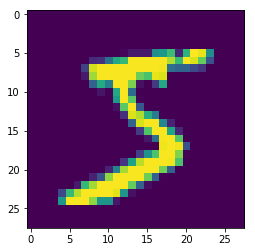

In [13]:
plt.imshow(img);
print(label)

In [0]:
import torchvision.transforms as transform

In [0]:
dataset = MNIST(root='data/', train=True, transform=transform.ToTensor())

In [17]:
type(dataset[0][0])

torch.Tensor

In [0]:
img_tensor, label = dataset[0]

In [22]:
img_tensor.shape

torch.Size([1, 28, 28])

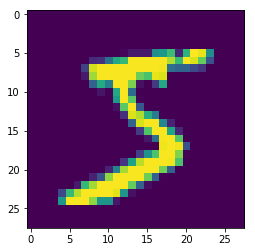

In [24]:
plt.imshow(img_tensor[0])

In [0]:
def split_indices(n, val_pct):
  n_val = int(n*val_pct)
  idx = torch.randperm(n)
  
  return idx[n_val:], idx[:n_val]

In [0]:
train_indices, val_indices = split_indices(len(dataset), 0.2)

In [29]:
len(train_indices)

48000

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [0]:
batch_size = 128

In [0]:
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset = dataset,batch_size=batch_size, sampler=train_sampler)

In [0]:
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset = dataset,batch_size=batch_size, sampler=val_sampler)

## Model Creation

In [0]:
import torch.nn as nn

In [0]:
input_size = 28*28
num_classes = 10

In [0]:
model = nn.Linear(input_size, num_classes)

In [41]:
model.weight.shape

torch.Size([10, 784])

In [42]:
model.bias.shape

torch.Size([10])

In [0]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = torch.reshape(xb, (-1, 784))
        out = self.linear(xb)
        return out

In [0]:
model = MnistModel()

In [0]:
for img, labels in train_loader:
  outputs = model(img)
  break

In [124]:
outputs.shape

torch.Size([128, 10])

In [0]:
import torch.nn.functional as f

In [0]:
probs = f.softmax(outputs, dim=1)

In [0]:
max_probs, pred = torch.max(probs, dim =1)

In [128]:
pred

tensor([5, 5, 8, 6, 7, 6, 4, 7, 6, 6, 8, 7, 8, 5, 8, 8, 3, 6, 8, 8, 6, 2, 8, 6,
        6, 8, 5, 8, 5, 5, 2, 8, 8, 5, 2, 4, 9, 8, 6, 0, 7, 2, 8, 6, 6, 8, 8, 2,
        7, 6, 8, 9, 8, 0, 5, 4, 6, 8, 9, 9, 6, 6, 8, 7, 5, 6, 5, 8, 0, 0, 6, 7,
        5, 6, 2, 2, 8, 8, 5, 2, 4, 6, 8, 8, 6, 6, 0, 6, 6, 2, 5, 6, 6, 2, 6, 6,
        8, 8, 7, 2, 5, 2, 6, 6, 6, 6, 8, 5, 8, 6, 2, 6, 5, 8, 6, 4, 6, 5, 6, 0,
        6, 8, 6, 6, 8, 6, 5, 5])

In [0]:
def accuracy(l1, l2):
  
  return torch.sum(l1==l2).item()/len(l1)

In [130]:
accuracy(pred, labels)

0.09375

In [0]:
loss_fn =  f.cross_entropy

In [0]:
loss = loss_fn(outputs, labels)

In [133]:
loss

tensor(2.3288, grad_fn=<NllLossBackward>)

In [0]:
learning_rate = 0.001

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Calculate loss
    preds = model(xb)
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [0]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [146]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3408, Accuracy: 0.0777


In [0]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [0]:
# Redifine model and optimizer
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [150]:
fit(20, model, f.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/20], Loss: 0.6658, accuracy: 0.8528
Epoch [2/20], Loss: 0.6540, accuracy: 0.8541
Epoch [3/20], Loss: 0.6431, accuracy: 0.8548
Epoch [4/20], Loss: 0.6329, accuracy: 0.8561
Epoch [5/20], Loss: 0.6234, accuracy: 0.8568
Epoch [6/20], Loss: 0.6145, accuracy: 0.8580
Epoch [7/20], Loss: 0.6062, accuracy: 0.8590
Epoch [8/20], Loss: 0.5984, accuracy: 0.8596
Epoch [9/20], Loss: 0.5911, accuracy: 0.8608
Epoch [10/20], Loss: 0.5841, accuracy: 0.8619
Epoch [11/20], Loss: 0.5776, accuracy: 0.8630
Epoch [12/20], Loss: 0.5713, accuracy: 0.8639
Epoch [13/20], Loss: 0.5654, accuracy: 0.8648
Epoch [14/20], Loss: 0.5598, accuracy: 0.8652
Epoch [15/20], Loss: 0.5544, accuracy: 0.8663
Epoch [16/20], Loss: 0.5493, accuracy: 0.8672
Epoch [17/20], Loss: 0.5445, accuracy: 0.8678
Epoch [18/20], Loss: 0.5398, accuracy: 0.8681
Epoch [19/20], Loss: 0.5353, accuracy: 0.8686
Epoch [20/20], Loss: 0.5311, accuracy: 0.8696


NameError: ignored